In [5]:
train_csv = '~/tmp/dfound_md/train.csv'

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

## load and split train metadata

In [11]:
original_train_df = pd.read_csv(train_csv)

In [12]:
idx_train, idx_val = train_test_split(
    original_train_df.index,
    test_size=0.1, 
    random_state=1
)

In [13]:
df = original_train_df

In [14]:
df.loc[idx_train, 'split'] = 'train'
df.loc[idx_val, 'split'] = 'validation'
df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'validation']

## load train features

In [15]:
import numpy as np
from tqdm import tqdm

train_features, train_labels = [], []
for index, row in tqdm(df_train.iterrows(), total=len(df_train)):
    train_features.append(np.load(row['feature_path']))
    train_labels.append(row['label'])
    

100%|██████████████████████████████████████████████████████████| 8856/8856 [00:36<00:00, 241.30it/s]


In [16]:
train_features = np.stack(train_features, axis=0)
train_labels = np.array(train_labels)
train_features.shape, train_labels.shape

((8856, 6144), (8856,))

## load validation features

In [17]:
import numpy as np
from tqdm import tqdm

val_features, val_labels = [], []
for index, row in tqdm(df_val.iterrows(), total=len(df_val)):
    val_features.append(np.load(row['feature_path']))
    val_labels.append(row['label'])

100%|████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 221.70it/s]


In [18]:
val_features = np.stack(val_features, axis=0)
val_labels = np.array(val_labels)
val_features.shape, val_labels.shape

((985, 6144), (985,))

## train logistic regression classifier

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lrc_model = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=1, max_iter=1000)
)
lrc_model.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=1))])

In [20]:
pred = lrc_model.predict(val_features)

In [21]:
acc = np.sum(pred == val_labels) / val_labels.size
acc

0.8873096446700508

In [22]:
from sklearn.metrics import precision_recall_fscore_support

prec_lrc, rec_lrc, f1_lrc, _ = precision_recall_fscore_support(
    val_labels, 
    pred, 
    average='binary'
)

for name, value in zip(
    ['precision', 'recall', 'f1'],
    [prec_lrc, rec_lrc, f1_lrc]
):
    print(f'{name}:\t{value:.4f}')

precision:	0.8844
recall:	0.8787
f1:	0.8815


In [23]:
# prob = lrc_model.predict_proba(val_features)
# prob

score_lrc = lrc_model.decision_function(val_features)

In [25]:
from sklearn.metrics import precision_recall_curve

prec_lrc, rec_lrc, thresholds_lrc = precision_recall_curve(
    val_labels,
    score_lrc
)

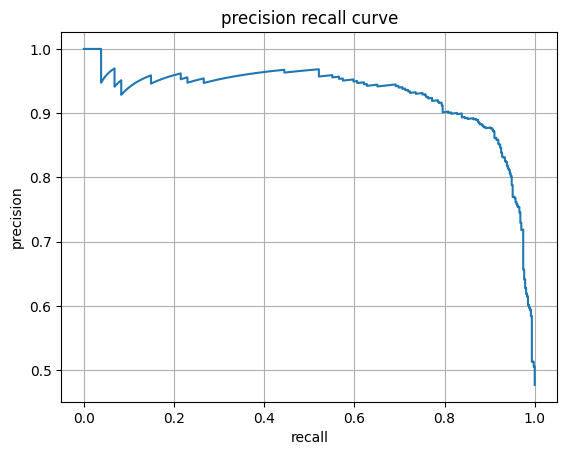

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(rec_lrc, prec_lrc)
plt.grid(which='both')


In [27]:
op_point = np.argmin(rec_lrc > 0.999)
prec_at_999_rec = prec_lrc[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall')

50.54% precision at 99.9% recall


## train SVM

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

svm_model = make_pipeline(StandardScaler(), LinearSVC(random_state=1))
svm_model.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=1))])

In [29]:
pred = svm_model.predict(val_features)
acc = np.sum(pred == val_labels) / val_labels.size
acc

0.8710659898477158

In [31]:
from sklearn.metrics import precision_recall_fscore_support

prec_svm, rec_svm, f1_svm, _ = precision_recall_fscore_support(
    val_labels, 
    pred, 
    average='binary'
)

for name, value in zip(
    ['precision', 'recall', 'f1'],
    [prec_svm, rec_svm, f1_svm]
):
    print(f'{name}:\t{value:.4f}')

precision:	0.8595
recall:	0.8723
f1:	0.8659


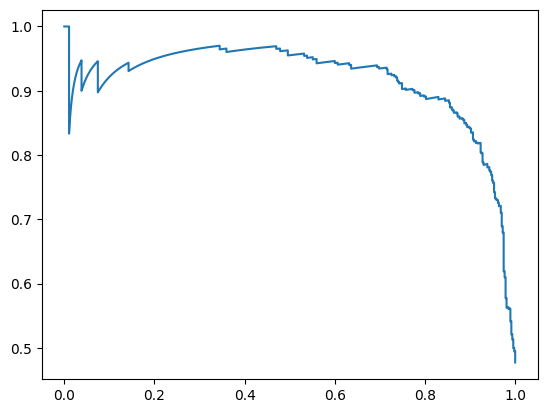

In [33]:
score = svm_model.decision_function(val_features)

prec_svm, rec_svm, thresholds_svm = precision_recall_curve(
    val_labels,
    score
)

plt.plot(rec_svm, prec_svm)

In [34]:
op_point = np.argmin(rec_svm > 0.999)
prec_at_999_rec = prec_svm[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall')

49.42% precision at 99.9% recall


# run on test set

In [35]:
test_csv = '~/tmp/dfound_md/test.csv'
test_df = pd.read_csv(test_csv)
test_df

,feature_path,label
0,/Users/mma0448/tmp/test_embeds/test_000001.npy,1
1,/Users/mma0448/tmp/test_embeds/test_000002.npy,1
2,/Users/mma0448/tmp/test_embeds/test_000003.npy,1
3,/Users/mma0448/tmp/test_embeds/test_000004.npy,1
4,/Users/mma0448/tmp/test_embeds/test_000005.npy,1
...,...,...
1995,/Users/mma0448/tmp/test_embeds/test_001996.npy,0
1996,/Users/mma0448/tmp/test_embeds/test_001997.npy,0
1997,/Users/mma0448/tmp/test_embeds/test_001998.npy,0
1998,/Users/mma0448/tmp/test_embeds/test_001999.npy,0


In [36]:
import numpy as np
from tqdm import tqdm

test_features, test_labels = [], []
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    test_features.append(np.load(row['feature_path']))
    test_labels.append(row['label'])

test_features = np.stack(test_features, axis=0)
test_labels = np.array(test_labels)
test_features.shape, test_labels.shape

100%|███████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 95.99it/s]


((2000, 6144), (2000,))

In [39]:
pred = lrc_model.predict(test_features)
acc = np.sum(pred == test_labels) / test_labels.size
acc

0.9045

In [41]:
from sklearn.metrics import precision_recall_fscore_support

prec_lrc, rec_lrc, f1_lrc, _ = precision_recall_fscore_support(
    test_labels, 
    pred, 
    average='binary'
)

for name, value in zip(
    ['precision', 'recall', 'f1'],
    [prec_lrc, rec_lrc, f1_lrc]
):
    print(f'{name}:\t{value:.4f}')

precision:	0.9166
recall:	0.8900
f1:	0.9031


In [43]:
score_lrc = lrc_model.decision_function(test_features)

prec_lrc, rec_lrc, thresholds_lrc = precision_recall_curve(
    test_labels,
    score_lrc
)

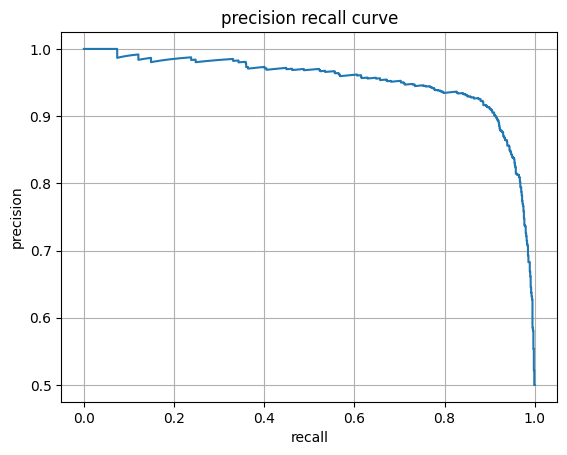

In [44]:
plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(rec_lrc, prec_lrc)
plt.grid(which='both')

In [45]:
op_point = np.argmin(rec_lrc > 0.999)
prec_at_999_rec = prec_lrc[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall')

50.00% precision at 99.9% recall


In [56]:
from pathlib import Path

# output_dir = Path('~/tmp/dfound_results')
np.save('lrc_recall.npy', rec_lrc)
np.save('lrc_precision.npy', prec_lrc)